In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "6"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import h5py 
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


Matplotlib created a temporary cache directory at /tmp/matplotlib-tdsp8fvy because the default path (/afs/inf.ed.ac.uk/user/n/nkudryas/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [5]:
dataset_name = f'chewie_10_07'
model_str='kl1_gauss'

bin_size_ms = 10

In [12]:
models_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/pbt-band-paper-slurm/{dataset_name}"

fac_dim, co_dim = 8,4
bw = 0.1
encod_seq_len = 101
encod_data_dim = 207
seed = 2
# model_names = ['240520_lfads_minloss_KL1', '240520_band_minloss_KL1']
model_names = [f'{model_name}_both_{fac_dim}f_{co_dim}c_{model_str}' for model_name in ['lfads','band']]
# model_names[0] += '_bs256'
model_dests = [f"{models_dest}/{model_name}" for model_name in model_names]

model_dests


['/disk/scratch2/nkudryas/BAND-torch/runs/pbt-band-paper-slurm/chewie_10_07/lfads_both_8f_4c_kl1_gauss',
 '/disk/scratch2/nkudryas/BAND-torch/runs/pbt-band-paper-slurm/chewie_10_07/band_both_8f_4c_kl1_gauss']

In [13]:
path = f'../../datasets/Chewie_CO_FF_2016-10-07_session_vel_all_spikes_go.h5'
data = h5py.File(path, 'r')
data.keys()

true_target_direction = data['valid_target_direction']

In [14]:
# Get the paths to all data files
both_pca = []
both_tsne = []
for model_name, model_dest in zip(model_names,model_dests):
    data_path = os.path.join(model_dest,'best_model',f'lfads_output_go.h5')
    # Data is binned at 10 ms
    with h5py.File(data_path) as f:
        print(f.keys())
        # Merge train and valid data for factors and rates
        train_ic = f['train_gen_init'][:]
        ic = f['valid_gen_init'][:]
  
    # PCA on initial conditions
    pca = PCA(n_components=2)
    pca.fit(train_ic)
    ic_pca = pca.transform(ic)
    print(train_ic.shape,ic_pca.shape)

    # t-SNE of initial conditions
    tsne = TSNE(n_components=2, perplexity=min(ic.shape[0]//2,30.0))
    ic_tsne = tsne.fit_transform(ic)
    print(ic_tsne.shape)
            
    both_pca.append(ic_pca)
    both_tsne.append(ic_tsne)



<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(465, 200) (116, 2)
(116, 2)
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_ind

In [15]:
def get_target_ids(true_target_direction):
    ''' substitute direction elements with ids '''
    uniq_dirs = np.unique(true_target_direction)
    true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])
    return true_label

target_ids = get_target_ids(true_target_direction)

In [16]:
help(plt.cm.ScalarMappable)

Help on class ScalarMappable in module matplotlib.cm:

class ScalarMappable(builtins.object)
 |  ScalarMappable(norm=None, cmap=None)
 |  
 |  A mixin class to map scalar data to RGBA.
 |  
 |  The ScalarMappable applies data normalization before returning RGBA colors
 |  from the given colormap.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, norm=None, cmap=None)
 |      Parameters
 |      ----------
 |      norm : `.Normalize` (or subclass thereof) or str or None
 |          The normalizing object which scales data, typically into the
 |          interval ``[0, 1]``.
 |          If a `str`, a `.Normalize` subclass is dynamically generated based
 |          on the scale with the corresponding name.
 |          If *None*, *norm* defaults to a *colors.Normalize* object which
 |          initializes its scaling based on the first data processed.
 |      cmap : str or `~matplotlib.colors.Colormap`
 |          The colormap used to map normalized data values to RGBA colors.
 |  
 | 

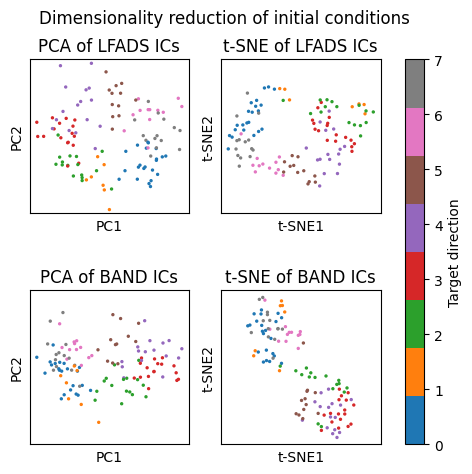

In [17]:
from matplotlib.colors import ListedColormap

fig, axes = plt.subplots(2,2,figsize=(5.2,5))
fig.suptitle('Dimensionality reduction of initial conditions')

ccolors = plt.get_cmap(cm.tab10)(np.arange(8, dtype=int))
cmap = ListedColormap(ccolors)

for model_name, model_dest, ic_pca, ic_tsne, ax in zip(['LFADS','BAND'], model_dests, both_pca, both_tsne, axes):
    ax[0].scatter(*ic_pca.T,c=target_ids,s=2,cmap=cmap)
    ax[0].set_title(f'PCA of {model_name} ICs')
    ax[0].set_xlabel('PC1')
    ax[0].set_ylabel('PC2')
    sm = ax[1].scatter(*ic_tsne.T,c=target_ids,s=2,cmap=cmap)
    ax[1].set_title(f't-SNE of {model_name} ICs')
    ax[1].set_xlabel('t-SNE1')
    ax[1].set_ylabel('t-SNE2')


# add colorbar
fig.colorbar(sm, ax=axes[:,1], orientation='vertical',label='Target direction')

for ax in axes.flatten():
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.subplots_adjust(hspace=0.5,right=0.8)

fig.savefig(f"figs/initial_conditions.pdf")

# TODO: add LDA score
